In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat

In [2]:
path = 'ex3data1.mat'
data = loadmat(path)
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
data['X'].shape, data['y'].shape

((5000, 400), (5000, 1))

In [4]:
type(data['X'])

numpy.ndarray

In [5]:
# 数字可视化
random_index = np.random.choice(data['X'].shape[0], 100) # 随机选择100张图片
random_images = data['X'][random_index, :] 
random_images.shape

(100, 400)

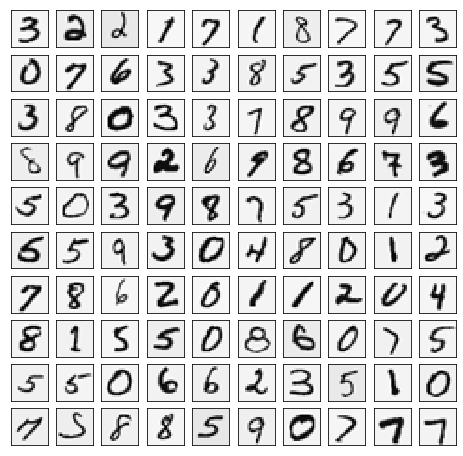

In [6]:
fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))
for r in range(10):
    for c in range(10):
        ax_array[r, c].matshow(np.array(random_images[10 * r + c].reshape((20, 20))).T, cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([])) 

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [8]:
def lr_cost_function(theta, X, y):
    theta = theta.reshape(1, theta.shape[0])
    h = sigmoid(X @ theta.T)
    m = X.shape[0]
    temp = -y * np.log(h) - (1 - y) * np.log(1-h)
    return  np.sum(temp) / m


def lr_gradient_function(theta, X, y):
    theta = theta.reshape(1, theta.shape[0])
    t = sigmoid(X @ theta.T) - y
    return (X.T @ t) / X.shape[0]

In [9]:
def lr_cost_function_reg(theta, X, y, lambda_reg):
    theta = theta.reshape(1, theta.shape[0])
    h = sigmoid(X @ theta.T)
    m = X.shape[0]
    temp1 = -y * np.log(h) - (1 - y) * np.log(1-h)
    temp2 = (theta**2)[:, 1:]
    return  np.sum(temp1) / m + lambda_reg * np.sum(temp2) / (2 * m)


def lr_gradient_function_reg(theta, X, y, lambda_reg): 
    theta = theta.reshape(1, theta.shape[0])
    t =  sigmoid(X @ theta.T) - y 
    grad = (X.T @ t) / X.shape[0] + lambda_reg / X.shape[0] * theta.T
    grad[0, 0] -= lambda_reg / X.shape[0] * theta[0, 0] #theta0 is not regularized
    return grad

In [10]:
from scipy.optimize import minimize

In [11]:
rows = data['X'].shape[0]
params = data['X'].shape[1]

all_theta = np.zeros((10, params + 1))

X = np.insert(data['X'], 0, values=np.ones(rows), axis=1)

theta = np.zeros(params + 1)

y_0 = np.array([1 if label == 0 else 0 for label in data['y']])
y_0 = np.reshape(y_0, (rows, 1))

X.shape, y_0.shape, theta.shape, all_theta.shape

((5000, 401), (5000, 1), (401,), (10, 401))

In [12]:
np.unique(data['y'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [13]:
def one_vs_all(X, y, num_labels, lambda_reg):
    all_theta = np.zeros((num_labels, X.shape[1] + 1))
    X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)  # 增加一列1
    
    for i in range(1, num_labels + 1):
        theta = np.zeros(X.shape[1])
        y_i = np.array([1 if label == i else 0 for label in y])
        y_i = y_i.reshape(X.shape[0], 1)
        # 求出每一类对应的参数theta
        fmin = minimize(fun=lr_cost_function_reg, x0=theta, args=(X, y_i, lambda_reg), method='TNC', jac=lr_gradient_function_reg)
        all_theta[i - 1, :] = fmin.x
    return all_theta

In [14]:
all_theta = one_vs_all(data['X'], data['y'], 10, 1)
all_theta, all_theta.shape

(array([[-2.38390063e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.30434014e-03, -7.35834117e-10,  0.00000000e+00],
        [-3.18346541e+00,  0.00000000e+00,  0.00000000e+00, ...,
          4.45909590e-03, -5.08378482e-04,  0.00000000e+00],
        [-4.79652829e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -2.86653661e-05, -2.47072633e-07,  0.00000000e+00],
        ...,
        [-7.98577339e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -8.95611013e-05,  7.22534341e-06,  0.00000000e+00],
        [-4.57234442e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.31929338e-03,  9.96321703e-05,  0.00000000e+00],
        [-5.40637718e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.16772458e-04,  7.89647650e-06,  0.00000000e+00]]),
 (10, 401))

In [15]:
def predict_all(X, all_theta):
    X = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)
    h = sigmoid(X @ all_theta.T)
    h_max = np.argmax(h, axis=1) # 返回每列最大值的下标0~9
    h_max += 1 # 1~10
    return h_max

In [16]:
y_pred = predict_all(data['X'], all_theta)
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, data['y'])]
accuracy = (sum(map(int, correct)) / float(len(correct)))
accuracy = np.sum(correct) / float(len(correct)) * 100
print (f'accuracy = {accuracy}%')

accuracy = 94.46%


In [17]:
# neural network
path = 'ex3weights.mat'
weight = loadmat(path)
theta1 = weight['Theta1']
theta2 = weight['Theta2']
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [18]:
# 插入bias
X2 = data['X']
X2 = np.insert(X2, 0, np.ones(X.shape[0]), 1)
y2 = data['y']
X2.shape, y2.shape

((5000, 401), (5000, 1))

In [19]:
# layer1
a1 = X2

In [20]:
# layer2
z2 = a1 @ theta1.T
a2 = sigmoid(z2)
z2.shape, a2.shape

((5000, 25), (5000, 25))

In [21]:
# layer3
a2 = np.insert(a2, 0, np.ones(a2.shape[0]), 1)
z3 = a2 @ theta2.T
a3 = sigmoid(z3)
z3.shape, a3.shape

((5000, 10), (5000, 10))

In [22]:
y_pred2 = np.argmax(a3, axis=1) + 1
correct2 = [1 if a==b else 0 for a, b in zip(y_pred2, data['y'])]
accuracy2 = np.sum(correct2) / float(len(correct2)) * 100
print(f'accuracy = {accuracy2}%')

accuracy = 97.52%
